<a href="https://colab.research.google.com/github/swatchai/cartopy/blob/master/asean_on_tm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Map of ASEAN Countries on Transverse-Mercator Projection

Status: 
OK with 'connected' local kernel, all modules already available.
OK with online service, need to install 'cartopy' on each connection.

Author: swatchai kriengkraipet

Summaries:
- This is Jupyter notebook
- Requires: Python 2.7 + matplotlib + cartopy + etc. packages
- Prepared for my github depository: https://github.com/swatchai/cartopy_asean_proj

TODO:
- labeling
- ticks
- legend

In [0]:
%matplotlib inline

In [0]:
!apt-get -qq install python-cartopy python3-cartopy

Advantages for using TM:
- shapes of areas are preserved
- good for areas with NS longer than EW
- curved meridians 

Disadvantages:
- difficult to plot labels with Cartopy
- moderate scale errors
- Myanmar looks much greater latitude
- Map tiles services do not provide this kind of images

#### Creating a Sub-class of Cartopy's Existing Map Projection

In [0]:
import cartopy   # v 0.14.2
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

# TransverseMercator central_longitude=115, others=defaults; see help below
# good due to symmetry E/W with central_longitude=115

class asean_tm(cartopy.crs.TransverseMercator):
    """
    TM projection for ASEAN domain.
    Ellipsoid is wgs84 (default)

    """
    def __init__(self):
        globe = cartopy.crs.Globe()  # default globe: wgs1984
        super(asean_tm, self).__init__(central_longitude=115, scale_factor=1.0, globe=globe)

    @property
    def x_limits(self):
        return (-2.95e6, 3.35e6)

    @property
    def y_limits(self):
        return (-1.5e6, 3.75e6)

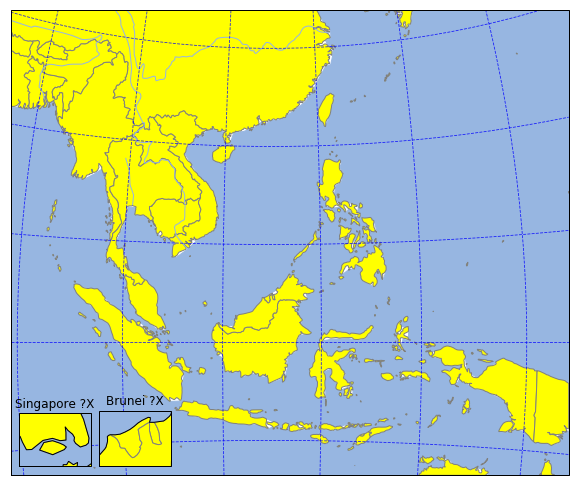

In [35]:
# This creates a plot of all ASEAN countries on TM projection with ...
# - oceans
# - coast lines
# - country boundaries (admin-0)
# - major rivers

# TODO: 
# - switches for layers ON/OFF
# - to set colors choices individually

import cartopy.feature as cfeature
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

watercolor = cfeature.COLORS['water']

fig = plt.figure(figsize=(10, 12))  # width x height in inches 
ax1 = plt.axes( projection=asean_tm() )   # make use of the proj

# feature: physical/110m_ocean.shp
# type: polygon
ax1.add_feature(cfeature.OCEAN, facecolor=watercolor)  

# feature: country shapes at medium scale
# type: polygon
admin0_50m = cfeature.NaturalEarthFeature('cultural', 'admin_0_countries', '50m', 
                                          edgecolor='gray', facecolor='yellow')
ax1.add_feature(admin0_50m)

# set True to plot rivers, set False to skip
major_rivers = True
if major_rivers:
    # 110m_rivers_lake_centerlines
    ax1.add_feature(cfeature.RIVERS, edgecolor=watercolor, facecolor='none')
    
# ax.coastlines(resolution='110m', color='black')

# set True to plot roads, set False to skip
road_10m_f = False
if road_10m_f:
    roads_10m = cfeature.NaturalEarthFeature('cultural', 'roads', '10m', 
                                             edgecolor='red', facecolor='none')
    ax1.add_feature(roads_10m)

# for visual inspection of map distortion
# set True to plot indicatrix, set False to skip 
plot_tissot = False
if plot_tissot:
    lats = range(-20,40,5)
    lons = range(80,150,5)
    ax1.tissot(rad_km=150000.0, lons=lons, lats=lats, n_samples=40, facecolor='gray', alpha=0.25)
    
gl = ax1.gridlines(draw_labels=False, \
                  xlocs=[80,90,100,110,120,130,140,150], \
                  ylocs=[-20,-10,0,10,20,30,40], \
                  linestyle='--', \
                  edgecolor='blue', \
                  alpha=0.85)  # parrallels/meridians
    

  
# for small countries
# ===================

norm_wid = 0.1
norm_hig = 0.1
pad_ratio = 70.0

# Singapore:
ax_sin = fig.add_axes([0.5, 0.5, norm_wid, norm_hig], projection=ccrs.PlateCarree(), \
                      label='inset_sin')
ax_sin.set_extent([103.38, 104.31, 1.12, 1.80], crs=ccrs.PlateCarree())
ax_sin.add_feature(admin0_50m)
#ax_sin.add_feature(cfeature.OCEAN, facecolor=watercolor)  # crude scale: 110m
ax_sin.add_feature(cfeature.NaturalEarthFeature('physical', 'ocean', '50m'), \
                  facecolor=watercolor)
ax_sin.coastlines(resolution='50m')
ax_sin.set_title('Singapore ?X')

# Brunei: 
ax_bru = fig.add_axes([0.5, 0.5, norm_wid, norm_hig], projection=ccrs.PlateCarree(), \
                      label='inset_bru')
ax_bru.set_extent([113.77, 115.55, 3.82, 5.18], crs=ccrs.PlateCarree())
ax_bru.add_feature(admin0_50m)
#ax_bru.add_feature(cfeature.OCEAN, facecolor=watercolor)
ax_bru.add_feature(cfeature.NaturalEarthFeature('physical', 'ocean', '50m'), \
                  facecolor=watercolor)
ax_bru.coastlines(resolution='50m')
ax_bru.set_title('Brunei ?X')

    
def reposition_nx(axis1, axis2, loc=1, xpad=0, ypad=0):
    # moves axis2 in relation of axis1
    # loc=corner_loc:
    #   1=UR/ 2=LR/ 3=LL/ 4=UL (match axes' corner)
    #   5=LR_axis1 touches LL_axis2  (bottom aligned)
    #   6=TODO:next_to_the_bottom    (top align)
    # xpad, ypad: in pixel units
    
    plt.draw() # get updated position for following computation
    p1 = axis1.get_position()
    p2 = axis2.get_position()

    if loc==2:
        # 2=LR OK
        axis2.set_position([xpad + p1.x1 - p2.width, ypad + p1.y0 , p2.width, p2.height])
    elif loc==3:
        # 3=LL OK
        axis2.set_position([xpad + p1.x0, ypad + p1.y0, p2.width, p2.height])
    elif loc==4:
        # 4=UL OK
        axis2.set_position([xpad + p1.x0, p1.y1 - p2.height, p2.width, p2.height])
    elif loc==5:
        # 5= LR_axis1 touches LL_axis2
        # use to position the 2nd and subsequent axes
        axis2.set_position([xpad + p1.x0 + p1.width, ypad + p1.y0, p2.width, p2.height])
    else:
        # 1=UR OK
        axis2.set_position([p1.x1 - p2.width, p1.y1 - p2.height, p2.width, p2.height])
      
    #newp = axis.get_position()
    #print("newp.x0, newp.x1, newp.y0, newp.y1", newp.x0, newp.x1, newp.y0, newp.y1)
    #print("newp.width, newp.height", newp.width, newp.height)
    
    p3 = axis2.get_position()
    #print("x0, y0, x1, y1, width, height:", str(p3.x0), str(p3.y0), str(p3.x1), str(p3.y1), str(p3.width), str(p3.height))
    
    # try plot with these coordinates (normalized 0-1)
    return [p3.x0,p3.x1], [p3.y0,p3.y1]
    
# get some metric of main axis
mx = ax1.get_position()
#mx.x0, mx.x1, mx.y0, mx.y1, 
mw, mh = mx.width, mx.height

# set padding size according to width of main axis
xpad = mw/pad_ratio
ypad = mh/pad_ratio

reposition_nx(ax1, ax_sin, loc=3, xpad=xpad, ypad=ypad)  #3= LL
#ax_sin.plot(ax_sin.get_xlim(), ax_sin.get_ylim(), marker='o')  # plot line across Singapore map

reposition_nx(ax_sin, ax_bru, loc=5, xpad=xpad, ypad=0)
#ax_bru.plot(ax_bru.get_xlim(), ax_bru.get_ylim(), marker='v')  # plot line across Brunei map


    
# Ticks -- error: Cannot handle non-rectangular coordinate systems.
# ax.set_xticks([80,90,100,110,120,130,140,150], minor=False, crs=ccrs.Geodetic())

#TypeError: Cannot label gridlines on a this plot.  Only PlateCarree and Mercator plots are currently supported.
#gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
#                  linewidth=1, color='gray', alpha=0.3, linestyle='--')

plt.show()

In [28]:
cfeature.NaturalEarthFeature('physical', 'ocean', '50m')

In [0]:
help(cfeature.NaturalEarthFeature)

**Coordinate transformation**

In [0]:
proj = asean_tm()   # coordinates in (x,y) meters

In [0]:
noproj = ccrs.PlateCarree()

In [9]:
proj.transform_point(80, 0, ccrs.PlateCarree())  # (long,lat) degrees to (x,y) meters

(-4165611.529505087, 0.0)

In [12]:
noproj.transform_point(-4165611.529505087, 0.0, asean_tm())  # reverse computation for checking

(80.00704676025656, 0.0)

In [8]:
proj.x_limits[0], proj.y_limits[0]

(-2950000.0, -1500000.0)

In [0]:
help(proj.transform_point)

---

About some warning messages:

When Tissot indicatrices are plotted, warning message says "some approx...". Nothing to worry, it is acceptable.

... \cartopy\mpl\geoaxes.py:586: UserWarning: Approximating coordinate system <cartopy._crs.Geodetic object at 0x00000000140C4FC0> with the PlateCarree projection.
  'PlateCarree projection.'.format(crs))



**Using Stamen Map Tiles**

Projection: Mercator with straight line graticule
No other projection if use map tiles from geo-services.

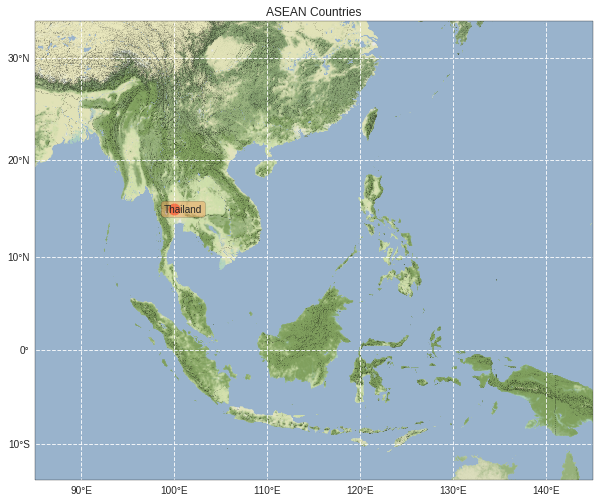

In [0]:
import matplotlib.pyplot as plt
from matplotlib.transforms import offset_copy

import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt

from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
   
  
# cimgt.MapQuestOSM()    # fails: MapQuestOpenAerial, 
# cimgt.StamenTerrain()  # good service/ result
# cimgt.MapboxTiles()  # needs access_token, map_id
# cimgt.GoogleTiles(desired_tile_form='RGB', style='satellite')  #OK

    
#maptiles = cimgt.GoogleTiles(desired_tile_form='RGB', style='satellite')  #sometimes not works
maptiles = cimgt.StamenTerrain()

# Create a GeoAxes in the tile's projection.
plt.figure(figsize=(10, 12))
ax = plt.axes(projection=maptiles.crs)


# Limit the extent of the map to a small longitude/latitude range.
# ax.set_extent([west, east, south, north], ccrs.PlateCarree())
ax.set_extent([85, 145, -12, 30])    #large extents, zoom level should be 

# Add the Stamen data at zoom level 8 for small area
# ASEAN extent, zoom level=?
ax.add_image(maptiles, 6)  # tile, zoome_level

# Add a marker
plt.plot(100, 15, marker='o', color='red', markersize=12,
         alpha=0.7, transform=ccrs.Geodetic())

# Use the cartopy interface to create a matplotlib transform object
# for the Geodetic coordinate system. We will use this along with
# matplotlib's offset_copy function to define a coordinate system which
# translates the text by tx, 10 pixels to the left.
tx = -10
geodetic_transform = ccrs.Geodetic()._as_mpl_transform(ax)
text_transform = offset_copy(geodetic_transform, units='dots', x=tx)

# Add text 25 pixels to the left of the volcano.
plt.text(100, 15, u'Thailand',
         verticalalignment = 'center', 
         horizontalalignment = 'left',
         transform = text_transform,
         bbox = dict(facecolor='sandybrown', alpha=0.5, boxstyle='round'))


gl = ax.gridlines(draw_labels=True, \
                  xlocs=[80,90,100,110,120,130,140,150], \
                  ylocs=[-20,-10,0,10,20,30,40], \
                  linestyle='--', \
                  edgecolor='blue', \
                  alpha=0.85)  # parrallels/meridians
gl.xlabels_top = gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

plt.title("ASEAN Countries")

plt.show()


In [0]:
help(cimgt.GoogleTiles)